In [1]:
from __future__ import division
import numpy as np
import os, sys
import matplotlib
#matplotlib.use('Agg')
%matplotlib nbagg
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict


In [2]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

In [41]:
df = pd.read_csv("../data/dns_data_cs/dns_all_20170124_20170130_sample.csv", sep="\t", error_bad_lines=False,
                names=['time', 'srcip', 'dstip', 'dnsquery'], ).fillna('')

In [ ]:
df.head()


## STATS

In [5]:
print "Total time of dns record [1.7GB]:", (df.iloc[-1]['time'] - df.iloc[0]['time']), "s"
print "Total number of queries: ", len(df)
print "Queries without source IP (are probably IPv6 so IP was not extracted): ", len(df[df['srcip']==''])

print "Unique source IPs (devices or homes):", len(df['srcip'].unique())
print "Unique destination IPs (DNS servers):", len(df['dstip'].unique())

print "Unique queries:", len(df['dnsquery'].unique())

Total time of dns record [1.7GB]: 50945.441681 s
Total number of queries:  27537421
Queries without source IP (are probably IPv6 so IP was not extracted):  148
Unique source IPs (devices or homes): 17743
Unique destination IPs (DNS servers): 1792
Unique queries: 666723


## KNOWN IOT DEVICES AND SPECIFIC DOMAINS

In [8]:
DNS_moderate_lookups = {
    'nest_therm': '.nest.com',
    'nest_cam': '.dropcam.com',
    'smartthings': '.smartthings.com',
    'pixstar': '.pix-star.com',
    'echo': 'device-metrics-us.amazon.com',
    'sharx': 'sharxsecurity.com',
    'august': '.august.com',
    'hue': '.meethue.com',
    #'apple': 'time-ios.apple.com',
    'apple': 'gs-loc.ls-apple.com',
    'ps': '.playstation.net',
    'xbox': 'xboxlive.com',
    'nintendo': 'nintendo.net',
}

In [9]:
iot_list = defaultdict(int)
for domain in DNS_moderate_lookups.values():
    if len(iot_list) == 0:
        iot_list = df['dnsquery'].str.contains(domain)
    else:
        iot_list = iot_list | df['dnsquery'].str.contains(domain)

In [10]:
df_iot = df[iot_list].copy()

In [11]:
len(df_iot)

28605

### Add corresponding device identified

In [12]:
inverse_DNS_lookups = {v: k for k, v in DNS_moderate_lookups.items()}
df_iot['device'] = ''

for domain in DNS_moderate_lookups.values():
    df_iot.loc[ df_iot['dnsquery'].str.contains(domain), 'device'] = inverse_DNS_lookups[domain]

In [13]:
df_iot.head()

,time,srcip,dstip,dnsquery,device
277,0.326137,10.8.252.6,10.8.0.5,device-metrics-us.amazon.com,echo
978,1.37333,10.8.117.252,10.8.0.6,us-prof.np.community.playstation.net,ps
3319,4.8464,10.8.75.213,10.8.0.5,device-metrics-us.amazon.com,echo
3491,5.10355,10.8.28.249,10.8.0.5,xsts.auth.xboxlive.com,xbox
3503,5.12828,10.8.28.249,10.8.0.6,xsts.auth.xboxlive.com,xbox


### Device vs unique source IPs

In [14]:
df_iot_count = df_iot.groupby(['srcip', 'device'])['dnsquery'].count().reset_index()
df_iot_count.head()

,srcip,device,dnsquery
0,10.8.0.179,apple,1
1,10.8.0.184,apple,2
2,10.8.0.22,apple,1
3,10.8.0.238,xbox,1
4,10.8.0.57,apple,3


In [15]:
gp = df_iot_count.groupby('device')

df_iot_dev_stats = pd.DataFrame( { 'count_srcip': gp['srcip'].count(),
                                  'mean_dnsquery_count': gp['dnsquery'].apply(lambda x: x.mean()),
                                  'std_dnsquery_count': gp['dnsquery'].apply(lambda x: x.std()) })

df_iot_dev_stats

,count_srcip,mean_dnsquery_count,std_dnsquery_count
device,,,
apple,2231,4.076647,7.413595
august,3,2.333333,2.309401
echo,531,15.802260,34.900566
hue,7,2.714286,3.302236
nest_cam,14,4.357143,3.855209
nest_therm,32,10.843750,19.597744
nintendo,39,23.461538,27.091314
ps,62,69.709677,98.517933
smartthings,5,4.400000,2.701851


# IDENTIFY IOT DEVICES

## NUM UNIQUE QUERIES PER DEVICE

In [16]:
gp1 = df.groupby(['srcip', 'dnsquery'])

In [17]:
df1 = gp1['time'].count().reset_index()

df1.head(20)

,srcip,dnsquery,time
0,,,148
1,10.24.117.145,_ldap._tcp.dc._msdcs.WORKGROUP.princeton.edu,1
2,10.24.117.145,_ldap._tcp.dc._msdcs.princeton.edu,2
3,10.24.117.145,ajax.cdnjs.com,2
4,10.24.117.145,http-test1.hola.org,2
5,10.24.117.145,isatap.princeton.edu,4
6,10.24.117.145,win8.ipv6.microsoft.com,2
7,10.24.117.145,wpad.princeton.edu,1
8,10.24.117.145,www.google.com,2
9,10.24.125.176,,6


In [18]:
len(df1)

5062521

In [19]:
# filter away empty/unknown queries or those not containing a period
#df2 = df1[~( (df1['dnsquery']=='') | (df1['dnsquery'].str.contains("<Unknown extended label>")) )]
df2 = df1[ (df1['dnsquery'].str.contains(".")) & (~df1['dnsquery'].str.contains("<"))]

In [20]:
len(df2)

5061798

In [21]:
# group query by sourceip and count num of individual queries per ip

gp2 = df2.groupby('srcip')
df3 = gp2['dnsquery'].count()

In [22]:
print "Number of source IPs =", len(df3)

Number of source IPs = 17633


In [23]:
len(df3)

17633

In [24]:
df4 = df3[df3<=200]
len( df4 )

9460

<IPython.core.display.Javascript object>


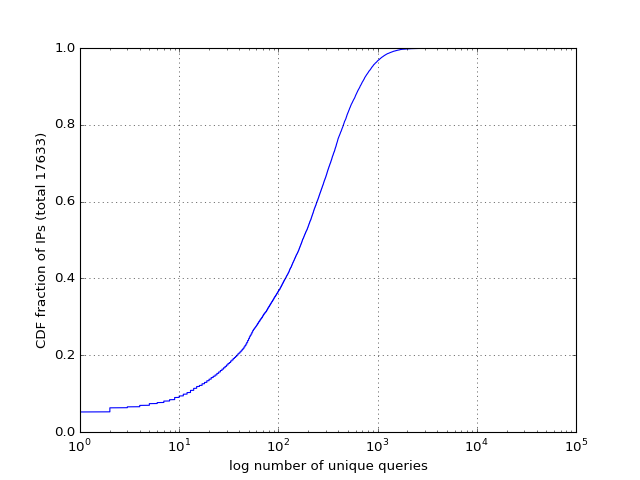

In [25]:
x,y = getCDF(df3.values)

fig1, ax1 = plt.subplots()
ax1.plot(x,y)
ax1.set_xscale("log", nonposx='clip')
ax1.grid(1)
ax1.set_xlabel('log number of unique queries')
ax1.set_ylabel('CDF fraction of IPs (total 17633)')
fig1.show()

<IPython.core.display.Javascript object>


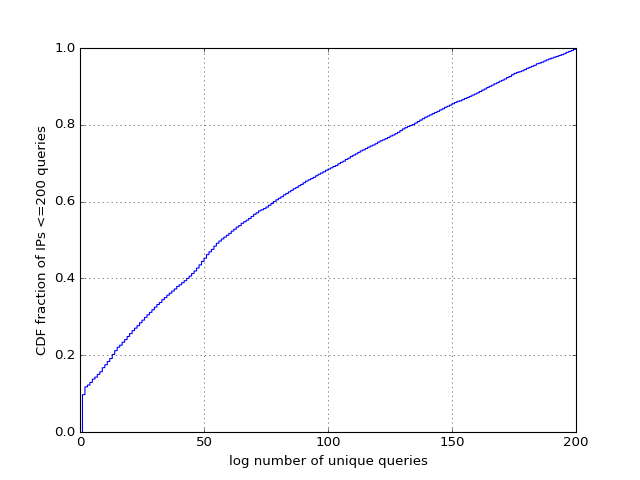

In [26]:
x,y = getCDF(df4.values)

fig1, ax1 = plt.subplots()
ax1.plot(x,y)
#ax1.set_xscale("log", nonposx='clip')
ax1.grid(1)
ax1.set_xlabel('log number of unique queries')
ax1.set_ylabel('CDF fraction of IPs <=200 queries')
fig1.show()

<IPython.core.display.Javascript object>


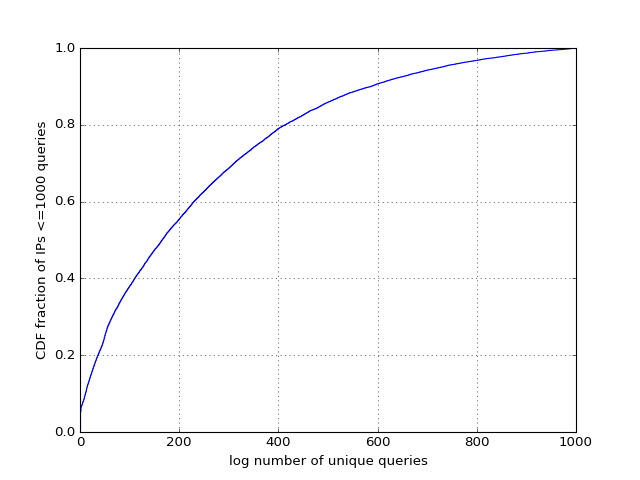

In [27]:
x,y = getCDF(df3[df3<=1000].values)

fig1, ax1 = plt.subplots()
ax1.plot(x,y)
#ax1.set_xscale("log", nonposx='clip')
ax1.grid(1)
ax1.set_xlabel('log number of unique queries')
ax1.set_ylabel('CDF fraction of IPs <=1000 queries')
fig1.show()

In [28]:
df3.sort()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


In [29]:
df_30 = df3[df3<=30]
print len(df_30)
print len(df3)
df_30

3075
17633


srcip
94.102.49.193       1
128.112.224.251     1
128.112.224.244     1
128.112.224.234     1
128.112.224.201     1
128.112.224.182     1
128.112.224.131     1
128.112.222.96      1
128.112.222.94      1
128.112.222.93      1
128.112.222.90      1
128.112.222.89      1
128.112.222.87      1
128.112.222.110     1
128.112.221.202     1
128.112.221.201     1
128.112.221.156     1
128.112.220.206     1
128.112.220.198     1
128.112.22.189      1
128.112.219.95      1
128.112.218.45      1
128.112.218.39      1
128.112.218.28      1
128.112.217.219     1
128.112.217.207     1
128.112.212.99      1
128.112.212.98      1
128.112.212.97      1
128.112.212.96      1
                   ..
10.8.8.10          30
10.9.64.217        30
10.8.218.243       30
10.9.68.91         30
10.6.49.97         30
10.6.49.41         30
10.9.151.163       30
10.9.155.58        30
10.6.49.42         30
10.9.96.221        30
10.9.22.184        30
10.8.84.27         30
10.9.27.167        30
10.6.52.195        30
10.9

In [30]:
df2.loc[gp2.indices['128.112.212.96']]

,srcip,dnsquery,time
4838733,128.112.134.236,ims314.Princeton.EDU,2


In [31]:
#df2.loc[gp2.indices['10.9.211.18']]

### Check IPs against df_iot

In [32]:
df_known_iot = df3.loc[df_iot_count.srcip].reset_index()
df_known_iot

,srcip,dnsquery
0,10.8.0.179,1326
1,10.8.0.184,318
2,10.8.0.22,59
3,10.8.0.238,147
4,10.8.0.57,151
5,10.8.0.85,448
6,10.8.1.10,526
7,10.8.1.115,158
8,10.8.1.135,625
9,10.8.1.157,348


In [33]:
df_iot_count.merge(df_known_iot, on='srcip')

,srcip,device,dnsquery_x,dnsquery_y
0,10.8.0.179,apple,1,1326
1,10.8.0.184,apple,2,318
2,10.8.0.22,apple,1,59
3,10.8.0.238,xbox,1,147
4,10.8.0.57,apple,3,151
5,10.8.0.85,apple,10,448
6,10.8.1.10,apple,3,526
7,10.8.1.115,echo,5,158
8,10.8.1.135,echo,1,625
9,10.8.1.157,apple,8,348


In [34]:
#df_temp = df[df['dnsquery'].str.contains('nest.com')]

In [35]:
#print( df_temp.to_string() ) 

In [36]:
#len(df_temp['srcip'].unique())

In [37]:
#df_temp2 = df[df['srcip']=='140.180.220.102']

In [38]:
#print( df_temp2.to_string() )

In [39]:
#df_temp2[df_temp2['dnsquery'].str.contains('tumblr')]